# Import modules

In [1]:
from diced import DicedStore
import json
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf

%matplotlib inline


# Get raw and groundtruth arrays from medulla7column repo through DICED

In [2]:
store = DicedStore("gs://flyem-public-connectome")
repo_grayscale = store.open_repo("medulla7column")
repo_groundtruth = store.open_repo("medulla7column")
grayscale = repo_grayscale.get_array("grayscale")
groundtruth = repo_groundtruth.get_array("groundtruth")


# Get some chunk of array from the index in roi.json

In [9]:
# Open roi.json file and specify as a numpy array:

with open('/media/haein/DATA/FlyEM/roi.json', 'r') as f:
    data = json.load(f)
    
roi_idx = np.array(data)
roi_idx[0:5]


array([[ 53,  77, 101, 149],
       [ 53,  78, 101, 149],
       [ 53,  79, 101, 149],
       [ 53,  80, 101, 149],
       [ 53,  81, 101, 149]])

## Create DataFrame contains voxel coordinates for groundtruth

In [10]:
# Create DataFrame from 'roi_idx':

col_name = ['z_start', 'y_start', 'x0_start', 'x1_start']
df = pd.DataFrame(roi_idx, columns=col_name)
df.head(5)


,z_start,y_start,x0_start,x1_start
0,53,77,101,149
1,53,78,101,149
2,53,79,101,149
3,53,80,101,149
4,53,81,101,149


In [11]:
# Translate to voxel coorinates:

df_voxel = df * 32
df_voxel.head(5)


,z_start,y_start,x0_start,x1_start
0,1696,2464,3232,4768
1,1696,2496,3232,4768
2,1696,2528,3232,4768
3,1696,2560,3232,4768
4,1696,2592,3232,4768


In [12]:
df_voxel.loc[0, "z_start"]

1696

In [13]:
# Make the columns contain slice information: 

roi_df = df_voxel.copy()

for idx, row in df_voxel.iterrows():
    roi_df.loc[idx, 'z_slice'] = slice(row[0], (row[0] + 32), None)
    roi_df.loc[idx, 'y_slice'] = slice(row[1], (row[1] + 32), None)
    roi_df.loc[idx, 'x_slice'] = slice(row[2], (row[3] + 32), None)

roi_df.head(5)


,z_start,y_start,x0_start,x1_start,z_slice,y_slice,x_slice
0,1696,2464,3232,4768,"slice(1696, 1728, None)","slice(2464, 2496, None)","slice(3232, 4800, None)"
1,1696,2496,3232,4768,"slice(1696, 1728, None)","slice(2496, 2528, None)","slice(3232, 4800, None)"
2,1696,2528,3232,4768,"slice(1696, 1728, None)","slice(2528, 2560, None)","slice(3232, 4800, None)"
3,1696,2560,3232,4768,"slice(1696, 1728, None)","slice(2560, 2592, None)","slice(3232, 4800, None)"
4,1696,2592,3232,4768,"slice(1696, 1728, None)","slice(2592, 2624, None)","slice(3232, 4800, None)"


In [14]:
# Check whether there is gap between the roi-cubes or not

z_start = (roi_df['z_start'] - 1696).unique()
print(np.where(z_start % 32 != 0))

y_start = (roi_df['y_start'] - 2464).unique()
print(np.where(y_start % 32 != 0))

x0_start = (roi_df['x0_start'] - 3232).unique()
print(np.where(x0_start % 32 != 0))

x1_start = (roi_df['x1_start'] - 4768).unique()
print(np.where(x1_start % 32 != 0))


(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)


In [15]:
# Get some chunk of raw and groundtruth images from the roi-cubes:

val = roi_df.iloc[0, :]

chunk_gry = grayscale[val[4], val[5], val[6]]
chunk_gt = groundtruth[val[4], val[5], val[6]]

# Print the size(shape) of the roi-cubic:

print('Each roi-cubic has {} of size.'.format(chunk_gry.shape))

Each roi-cubic has (32, 32, 1568) of size.


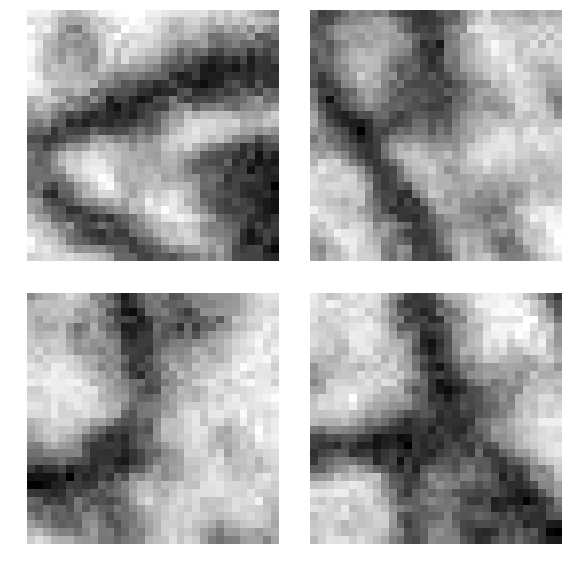

In [72]:
# Plotting several images from the array

plt.figure(figsize=(8, 8))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(chunk_gry[:, :, i * 100], cmap='gray')
    plt.imshow(chunk_gt[:, :, i * 100], alpha=0.5)
    plt.axis('off')
    #plt.title('X{}'.format(3232 + i * 100), fontsize=24)
    
plt.tight_layout()
plt.savefig('example2.png')

plt.show()


# Where is synapse?

In [24]:
# Load the synapse.json file:

with open('/media/haein/DATA/FlyEM/synapse.json', 'r') as f:
    synapse_json = json.load(f)
    

## Exploring the structure of the synapse.json

In [25]:
# Get the location of specific 'T-bar': 

data = synapse_json['data'][22]
loc_tbar = data['T-bar']['location']
print("The voxel coordinates of T-bar is [x, y, z] = " + str(loc_tbar))

# Get the locations of its 'partners':

partners = data['partners']
loc_part = [partners[i]['location'] for i in range(len(partners))]

for i, loc in enumerate(loc_part):
    print("The voxel coordinates of its partner {} is [x, y, z] = ".format(i) + str(loc_part[i]))


The voxel coordinates of T-bar is [x, y, z] = [1888, 3111, 7120]
The voxel coordinates of its partner 0 is [x, y, z] = [1884, 3090, 7118]
The voxel coordinates of its partner 1 is [x, y, z] = [1880, 3114, 7111]


## Create the DataFrame which contains of information about T-bars and their partners: synapse_df

In [26]:
# Get all of the T-bar locations in synapse.json:

data = synapse_json['data']

tbar_loc_list = []

for i in range(len(data)):
    tbar = data[i]['T-bar']
    x, y, z = tbar['location']
    tbar_loc_list.append([i, tbar['body ID'], x, y, z])

# Create the DataFrame of T-bar:

col_name = ['data', 'T-bar body ID', 'T-bar loc (x)', 'T-bar loc (y)', 'T-bar loc (z)']

tbar_df = pd.DataFrame(tbar_loc_list, columns=col_name)
print('The DataFrame of tbar_df would have ' + str(len(tbar_df)) + ' of rows')
tbar_df.tail(5)
    

The DataFrame of tbar_df would have 52871 of rows


,data,T-bar body ID,T-bar loc (x),T-bar loc (y),T-bar loc (z)
52866,52866,39326,5015,3301,1731
52867,52867,20789,5015,3653,1876
52868,52868,39727,5017,3134,1834
52869,52869,28700,5017,3468,2353
52870,52870,82080,5017,3695,1906


In [27]:
# Get all of the Partners locations corresponding to T-bars in synapse.json:

data = synapse_json['data']

partners_loc_list = []

for i in range(len(data)):
    partners = data[i]['partners']
    for j in range(len(partners)):
        x, y, z = partners[j]['location']
        partners_loc_list.append([i, partners[j]['body ID'], x, y, z])
    
# Create the DataFrame of Partners:

col_name = ['data', 'partner body ID', 'partner loc (x)', 'partner loc (y)', 'partner loc (z)']

partner_df = pd.DataFrame(partners_loc_list, columns=col_name)

print('The DataFrame of partner_df would have ' + str(len(partner_df)) + ' of rows')
partner_df.tail(5)
    

The DataFrame of partner_df would have 313219 of rows


,data,partner body ID,partner loc (x),partner loc (y),partner loc (z)
313214,52869,84374,5007,3457,2368
313215,52870,42310,5010,3684,1906
313216,52870,16699,4999,3695,1906
313217,52870,33690,5003,3704,1896
313218,52870,40513,4998,3701,1916


In [28]:
# Merge tbar_df and partner_df via 'outer' join:

synapse_df = tbar_df.merge(partner_df, on='data', how='inner')

print('The DataFrame of synapse_df would have ' + str(len(synapse_df)) + ' of rows')
synapse_df.tail(5)


The DataFrame of synapse_df would have 313219 of rows


,data,T-bar body ID,T-bar loc (x),T-bar loc (y),T-bar loc (z),partner body ID,partner loc (x),partner loc (y),partner loc (z)
313214,52869,28700,5017,3468,2353,84374,5007,3457,2368
313215,52870,82080,5017,3695,1906,42310,5010,3684,1906
313216,52870,82080,5017,3695,1906,16699,4999,3695,1906
313217,52870,82080,5017,3695,1906,33690,5003,3704,1896
313218,52870,82080,5017,3695,1906,40513,4998,3701,1916


In [29]:
# 51994 would be eliminated when applying the condition 
# to exclude the data located outside of the box:

synapse_df[(synapse_df['T-bar loc (x)'] == 4797) & (synapse_df['T-bar loc (y)'] == 3546) & (synapse_df['T-bar loc (z)'] == 1696)]

,data,T-bar body ID,T-bar loc (x),T-bar loc (y),T-bar loc (z),partner body ID,partner loc (x),partner loc (y),partner loc (z)
308490,51994,40403,4797,3546,1696,40850,4783,3538,1691
308491,51994,40403,4797,3546,1696,41492,4793,3532,1696
308492,51994,40403,4797,3546,1696,19604,4783,3547,1701
308493,51994,40403,4797,3546,1696,414418,4784,3559,1696


## How to specify where T-bars and their partners in the roi-cubics ? 

In [30]:
# Specify the min-max values on each axis

z_min = roi_df['z_start'].min()
z_max = roi_df['z_start'].max() + 32
y_min = roi_df['y_start'].min()
y_max = roi_df['y_start'].max() + 32
x_min = roi_df['x0_start'].min()
x_max = roi_df['x1_start'].max() +32


In [31]:
# Set index to remove T-bar or their partners are located at the outside of boundary:  

synapse_df.set_index(['data'], inplace=True)

# Extract T-bars and their partners place in roi-cubics:  

cond_z = ((synapse_df['T-bar loc (z)'] < z_min) |
          (synapse_df['T-bar loc (z)'] > z_max) |
          (synapse_df['partner loc (z)'] < z_min) |
          (synapse_df['partner loc (z)'] > z_max))
cond_y = ((synapse_df['T-bar loc (y)'] < y_min) |
          (synapse_df['T-bar loc (y)'] > y_max) |
          (synapse_df['partner loc (y)'] < y_min) |
          (synapse_df['partner loc (y)'] > y_max))
cond_x = ((synapse_df['T-bar loc (x)'] <  x_min) |
          (synapse_df['T-bar loc (x)'] >  x_max) |
          (synapse_df['partner loc (x)'] <  x_min) |
          (synapse_df['partner loc (x)'] > x_max))

synapse_df.drop(synapse_df[cond_z | cond_y | cond_x].index, inplace=True)
print('The DataFrame of synapse_df would have ' + str(len(synapse_df)) + ' of rows by getting rid of outer points from the roi-cubics')
synapse_df.tail(6)


The DataFrame of synapse_df would have 274734 of rows by getting rid of outer points from the roi-cubics


,T-bar body ID,T-bar loc (x),T-bar loc (y),T-bar loc (z),partner body ID,partner loc (x),partner loc (y),partner loc (z)
data,,,,,,,,
52004,28653,4800,2787,2078,16677,4782,2783,2078
52004,28653,4800,2787,2078,82593,4788,2773,2065
52004,28653,4800,2787,2078,16455,4782,2795,2078
52004,28653,4800,2787,2078,79793,4790,2799,2069
52004,28653,4800,2787,2078,80014,4785,2789,2093
52004,28653,4800,2787,2078,26544,4791,2806,2093


In [32]:
# Save synapse_df to csv: synapse_roi.csv

synapse_df.to_csv('synapse_roi.csv')


# Plotting a T-bar and its partners on the raw image: 24787

In [33]:
# Display the data '24787':

synapse_df.loc[24787]


,T-bar body ID,T-bar loc (x),T-bar loc (y),T-bar loc (z),partner body ID,partner loc (x),partner loc (y),partner loc (z)
data,,,,,,,,
24787,7021,3318,2493,1723,7131,3299,2495,1718
24787,7021,3318,2493,1723,414,3302,2477,1718
24787,7021,3318,2493,1723,8343,3314,2469,1718
24787,7021,3318,2493,1723,7463,3331,2466,1718
24787,7021,3318,2493,1723,9423,3294,2489,1728


In [34]:
# Get the array contains T-bar and its partners:

img = grayscale[1718:1729, 2466-35:2496+35, 3294-31:3332+31]
gt = groundtruth[1718:1729, 2466-35:2496+35, 3294-31:3332+31]

In [35]:
# Make the DataFrame includes the loc and its ID for plotting in convenience:

synapse_one = synapse_df.loc[24787, :]

loc = np.concatenate((synapse_one.iloc[0, 0:4].values.reshape(-1,4), 
                      synapse_one.iloc[:, 4:].values), axis=0)

loc_df = pd.DataFrame(loc, columns=['ID', 'x', 'y', 'z'])

x_start = 3294-31
y_start = 2466-35
z_start = 1718

loc_df['x'] = loc_df['x'] - x_start
loc_df['y'] = loc_df['y'] - y_start
loc_df['z'] = loc_df['z'] - z_start

loc_df = loc_df[['z', 'y', 'x', 'ID']]
loc_df


,z,y,x,ID
0,5,62,55,7021
1,0,64,36,7131
2,0,46,39,414
3,0,38,51,8343
4,0,35,68,7463
5,10,58,31,9423


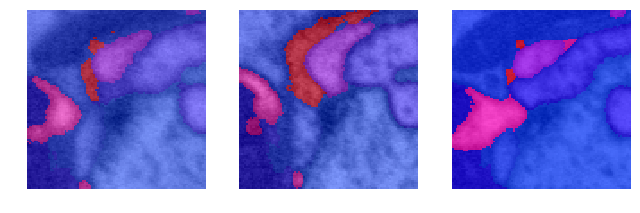

In [71]:
# Plot the images and annotate the locations of T-bar and its partners:

plt.figure(figsize=(9, 3))

# Subplot the T-bar:

plt.subplot(1, 3, 1)
z, y, x, ID = loc_df.loc[0]
plt.imshow(img[z, :, :], cmap='gray')
plt.imshow(gt[z, :, :], cmap='gist_rainbow', alpha=0.5)
# plt.annotate("{}".format(ID), fontsize=10, xy=(y, x), xytext = (y+10, x+10),
#              arrowprops=dict(facecolor='red', shrink=0.05))
#plt.title("T-bar", fontsize=15)
plt.axis('off')

# Subplot partners:

plt.subplot(1, 3, 2)

for idx, row in loc_df.iloc[1:5].iterrows():
    z, y, x, ID = row
    plt.imshow(img[z, :, :], cmap='gray')
    plt.imshow(gt[z, :, :], cmap='gist_rainbow', alpha=0.5)
#     plt.annotate("{}".format(ID), fontsize=10, xy=(y, x), xytext = (y+10, x+10),
#                  arrowprops=dict(facecolor='blue', shrink=0.05))
#plt.title("Partner", fontsize=15)
plt.axis('off')

# Subplot partner located on another layer:

plt.subplot(1, 3, 3)
z, y, x, ID = loc_df.iloc[-1]
plt.imshow(img[z, :, :], cmap='gray')
plt.imshow(gt[z, :, :], cmap='gist_rainbow', alpha=0.7)
# plt.annotate("{}".format(ID), fontsize=10, xy=(y, x), xytext = (y+10, x+10),
#              arrowprops=dict(facecolor='blue', shrink=0.05))
#plt.title("Partner", fontsize=15)
plt.axis('off')

plt.tight_layout()
plt.savefig('example_groundtruth.png')
plt.show()


In [37]:
x = np.empty((9186, 65))

In [33]:
for idx, row in roi_df.iterrows():
    x_loc = np.arange(row[2], row[3]+32, 32)
    x[idx][:len(x_loc)] = x_loc

In [34]:
x_loc_df = pd.DataFrame(x, dtype='int32')
x_loc_df.replace(0, np.nan, inplace=True)
x_loc_df.head(5)


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,3232,3264,3296,3328,3360,3392,3424,3456,3488,3520,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3232,3264,3296,3328,3360,3392,3424,3456,3488,3520,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3232,3264,3296,3328,3360,3392,3424,3456,3488,3520,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3232,3264,3296,3328,3360,3392,3424,3456,3488,3520,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3232,3264,3296,3328,3360,3392,3424,3456,3488,3520,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
df = pd.concat([roi_df, x_loc_df], axis=1)
col_name = ['z_start', 'y_start', 'x_from', 'x_to', 'z_slice', 'y_slice', 'x_slice']

for i in range(65):
    col_name.append('x{}_start'.format(i))

df.columns = col_name
df.head(5)

,z_start,y_start,x_from,x_to,z_slice,y_slice,x_slice,x0_start,x1_start,x2_start,...,x55_start,x56_start,x57_start,x58_start,x59_start,x60_start,x61_start,x62_start,x63_start,x64_start
0,1696,2464,3232,4768,"slice(1696, 1728, None)","slice(2464, 2496, None)","slice(3232, 4800, None)",3232,3264,3296,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1696,2496,3232,4768,"slice(1696, 1728, None)","slice(2496, 2528, None)","slice(3232, 4800, None)",3232,3264,3296,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1696,2528,3232,4768,"slice(1696, 1728, None)","slice(2528, 2560, None)","slice(3232, 4800, None)",3232,3264,3296,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1696,2560,3232,4768,"slice(1696, 1728, None)","slice(2560, 2592, None)","slice(3232, 4800, None)",3232,3264,3296,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1696,2592,3232,4768,"slice(1696, 1728, None)","slice(2592, 2624, None)","slice(3232, 4800, None)",3232,3264,3296,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
# Save roi_df to csv: roi_df.csv

roi_df.to_csv('roi_df.csv')

# Let's find out intersections and make big rectangular pillar!

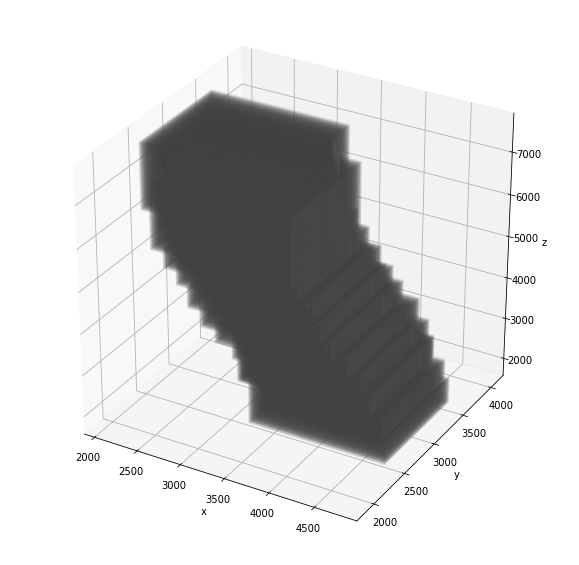

In [38]:
roi_plot = plt.figure(figsize=(10, 10)).gca(projection='3d')

zs = df.iloc[:, 0]
ys = df.iloc[:, 1]
xs = df.iloc[:, 2]
dx = (df.iloc[:, 3] - df.iloc[:, 2])
roi_plot.bar3d(xs, ys, zs, dx, 32, 32, color='gray', alpha=0.1)
    
roi_plot.set_xlabel('x')
roi_plot.set_ylabel('y')
roi_plot.set_zlabel('z')
plt.show()
